# TypeScript Wasm Algorithms Comparison Result

In [1]:
import os
import sys
from typing import Optional, List
from pydantic import BaseModel, Field
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

plt.style.use('ggplot')

In [2]:
result_filepath = "../data/benchmark-results-2025-05-09.csv"
df = pd.read_csv(result_filepath)

output_dir = Path("../images")
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
df.head()

,TestType,Size,Implementation,Iteration,Time(ms),Memory(MB)
0,Sorting,1000,TypeScript,1,54.76,6.67
1,Sorting,1000,WebAssembly,1,43.82,0.20
2,Sorting,1000,TypeScript,2,12.32,8.42
3,Sorting,1000,WebAssembly,2,49.41,1.51
4,Sorting,1000,TypeScript,3,65.47,8.59


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TestType        30000 non-null  object 
 1   Size            30000 non-null  int64  
 2   Implementation  30000 non-null  object 
 3   Iteration       30000 non-null  int64  
 4   Time(ms)        30000 non-null  float64
 5   Memory(MB)      30000 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.4+ MB


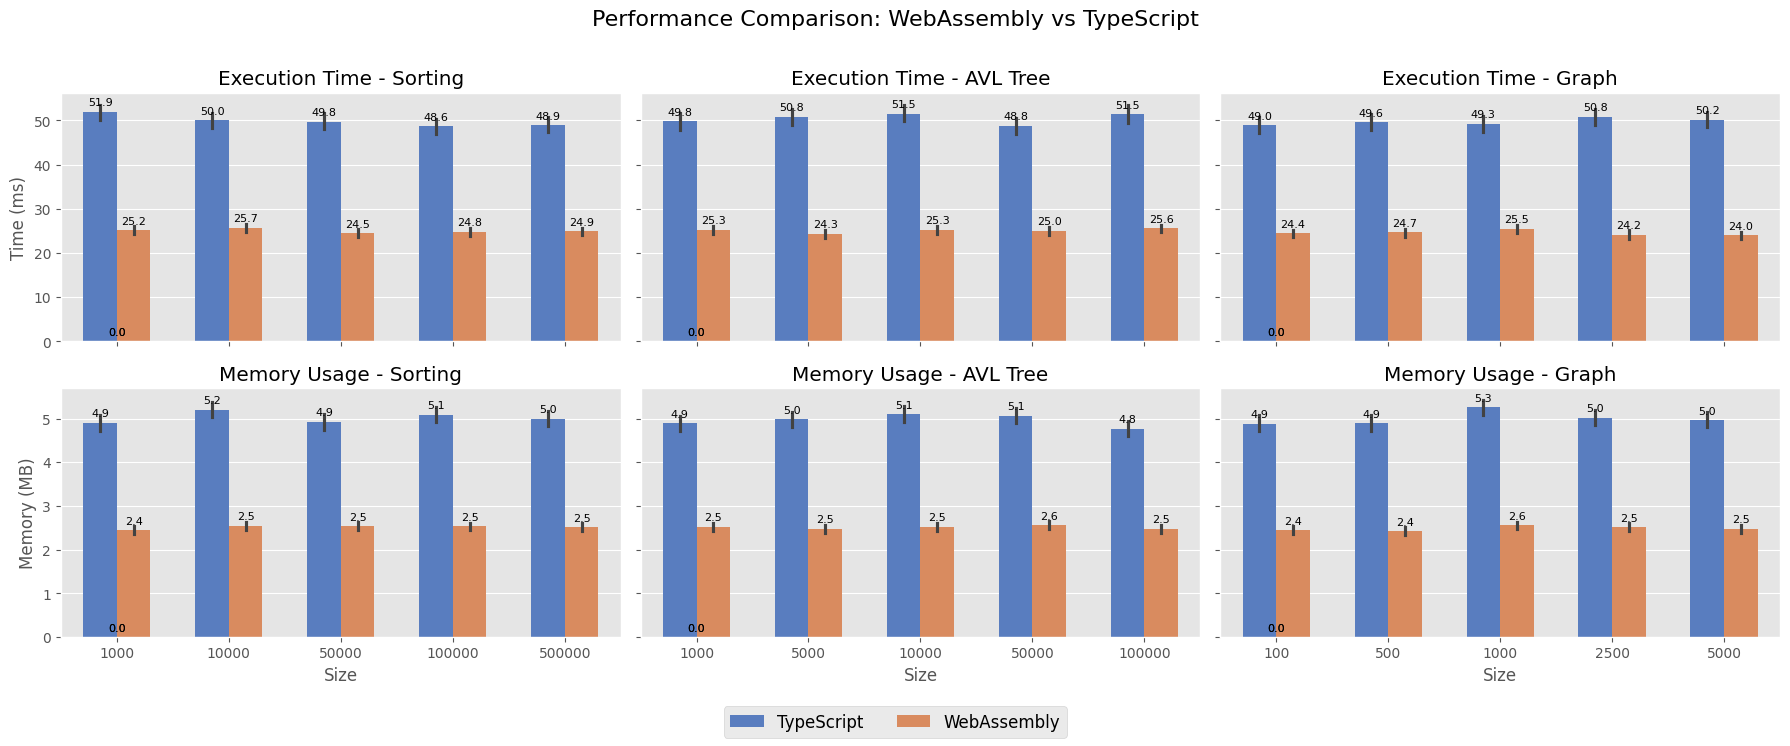

In [5]:
test_types = df["TestType"].unique()
num_cols = len(test_types)

fig, axes = plt.subplots(nrows=2, ncols=num_cols, figsize=(6 * num_cols, 7.5), sharex='col', sharey='row')

for i, test_type in enumerate(test_types):
    df_sub = df[df["TestType"] == test_type]

    # Time(ms)
    sns.barplot(
        data=df_sub,
        x="Size", y="Time(ms)",
        hue="Implementation", errorbar="ci", palette="muted", ax=axes[0, i],
        width=0.6
    )
    axes[0, i].set_title(f"Execution Time - {test_type}")
    axes[0, i].set_xlabel("Size")
    axes[0, i].set_ylabel("Time (ms)")

    for p in axes[0, i].patches:
        height = p.get_height()
        if not pd.isna(height):
            axes[0, i].annotate(
                f"{height:.1f}",
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=8, xytext=(0, 3),
                textcoords="offset points"
            )

    # Memory(MB)
    sns.barplot(
        data=df_sub,
        x="Size", y="Memory(MB)",
        hue="Implementation", errorbar="ci", palette="muted", ax=axes[1, i],
        width=0.6
    )
    axes[1, i].set_title(f"Memory Usage - {test_type}")
    axes[1, i].set_xlabel("Size")
    axes[1, i].set_ylabel("Memory (MB)")

    for p in axes[1, i].patches:
        height = p.get_height()
        if not pd.isna(height):
            axes[1, i].annotate(
                f"{height:.1f}",
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=8, xytext=(0, 3),
                textcoords="offset points"
            )
    
    axes[0, i].legend().remove()
    axes[1, i].legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels), fontsize="large")

plt.tight_layout(rect=[0, 0.06, 1, 0.92])
fig.suptitle("Performance Comparison: WebAssembly vs TypeScript", fontsize=16)

output_filepath = output_dir / f"performance_comparison_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
plt.savefig(output_filepath, dpi=300, bbox_inches='tight')

plt.show()


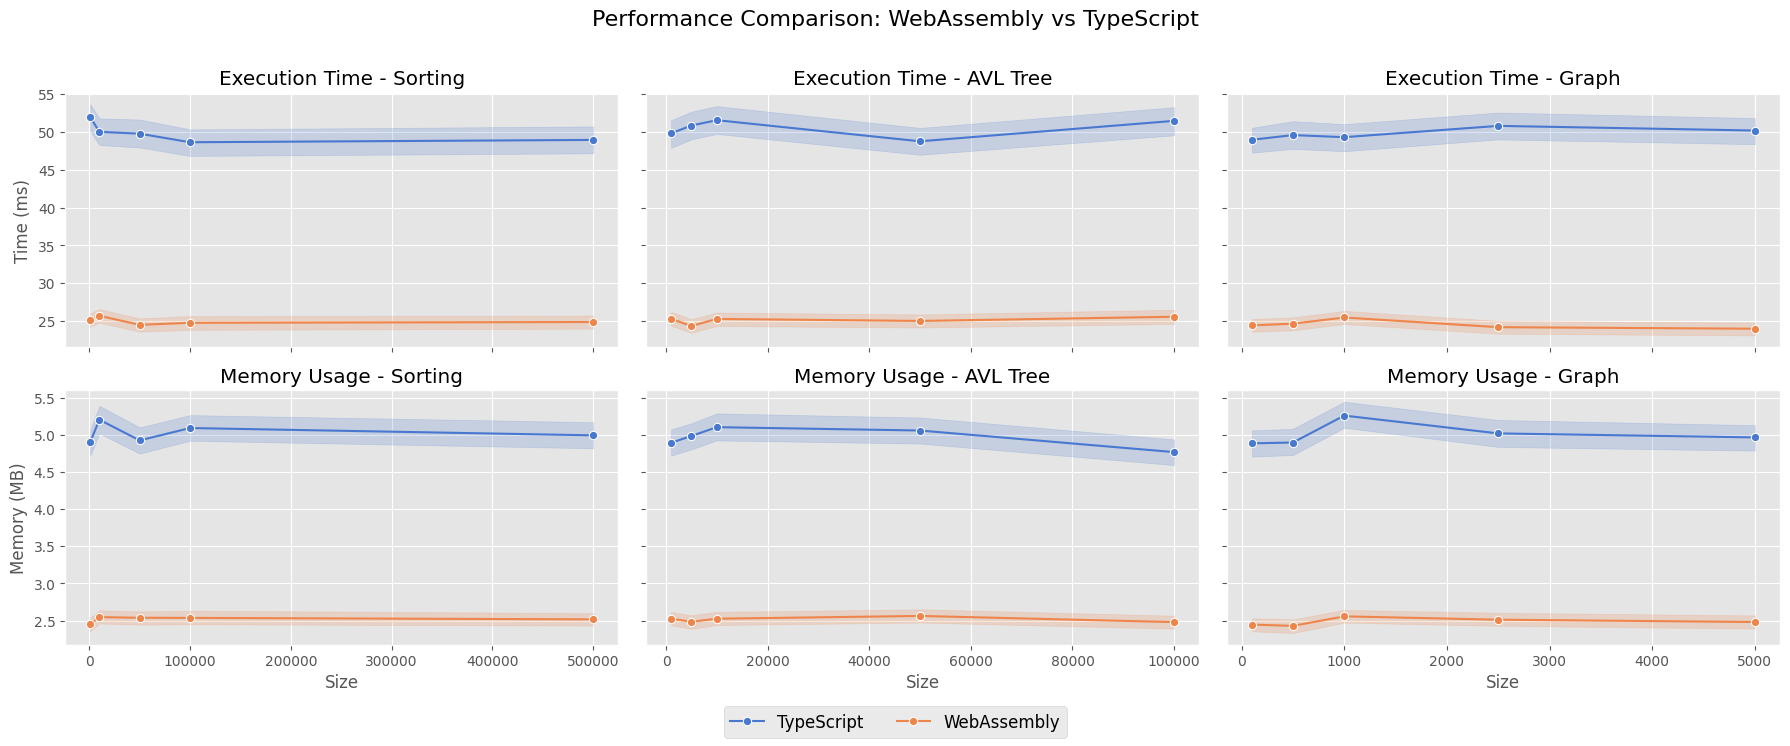

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=num_cols, figsize=(6 * num_cols, 7.5), sharex='col', sharey='row')

for i, test_type in enumerate(test_types):
    df_sub = df[df["TestType"] == test_type]

    # Time(ms)
    sns.lineplot(
        data=df_sub,
        x="Size", y="Time(ms)",
        hue="Implementation", marker="o", ax=axes[0, i],
        palette="muted"
    )
    axes[0, i].set_title(f"Execution Time - {test_type}")
    axes[0, i].set_xlabel("Size")
    axes[0, i].set_ylabel("Time (ms)")

    # Memory(MB)
    sns.lineplot(
        data=df_sub,
        x="Size", y="Memory(MB)",
        hue="Implementation", marker="o", ax=axes[1, i],
        palette="muted"
    )
    axes[1, i].set_title(f"Memory Usage - {test_type}")
    axes[1, i].set_xlabel("Size")
    axes[1, i].set_ylabel("Memory (MB)")

    axes[0, i].legend().remove()
    axes[1, i].legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels), fontsize="large")

plt.tight_layout(rect=[0, 0.05, 1, 0.92])
fig.suptitle("Performance Comparison: WebAssembly vs TypeScript", fontsize=16)

output_filepath = output_dir / f"performance_comparison_line_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
plt.savefig(output_filepath, dpi=300, bbox_inches='tight')

plt.show()


In [7]:
grouped = df.groupby(["TestType", "Size", "Implementation"]).agg({
    "Time(ms)": "mean",
    "Memory(MB)": "mean"
}).reset_index()

pivot_time = grouped.pivot_table(index=["TestType", "Size"], columns="Implementation", values="Time(ms)").reset_index()
pivot_memory = grouped.pivot_table(index=["TestType", "Size"], columns="Implementation", values="Memory(MB)").reset_index()

pivot_time["TimeRatio"] = pivot_time["TypeScript"] / pivot_time["WebAssembly"]
pivot_memory["MemoryRatio"] = pivot_memory["TypeScript"] / pivot_memory["WebAssembly"]

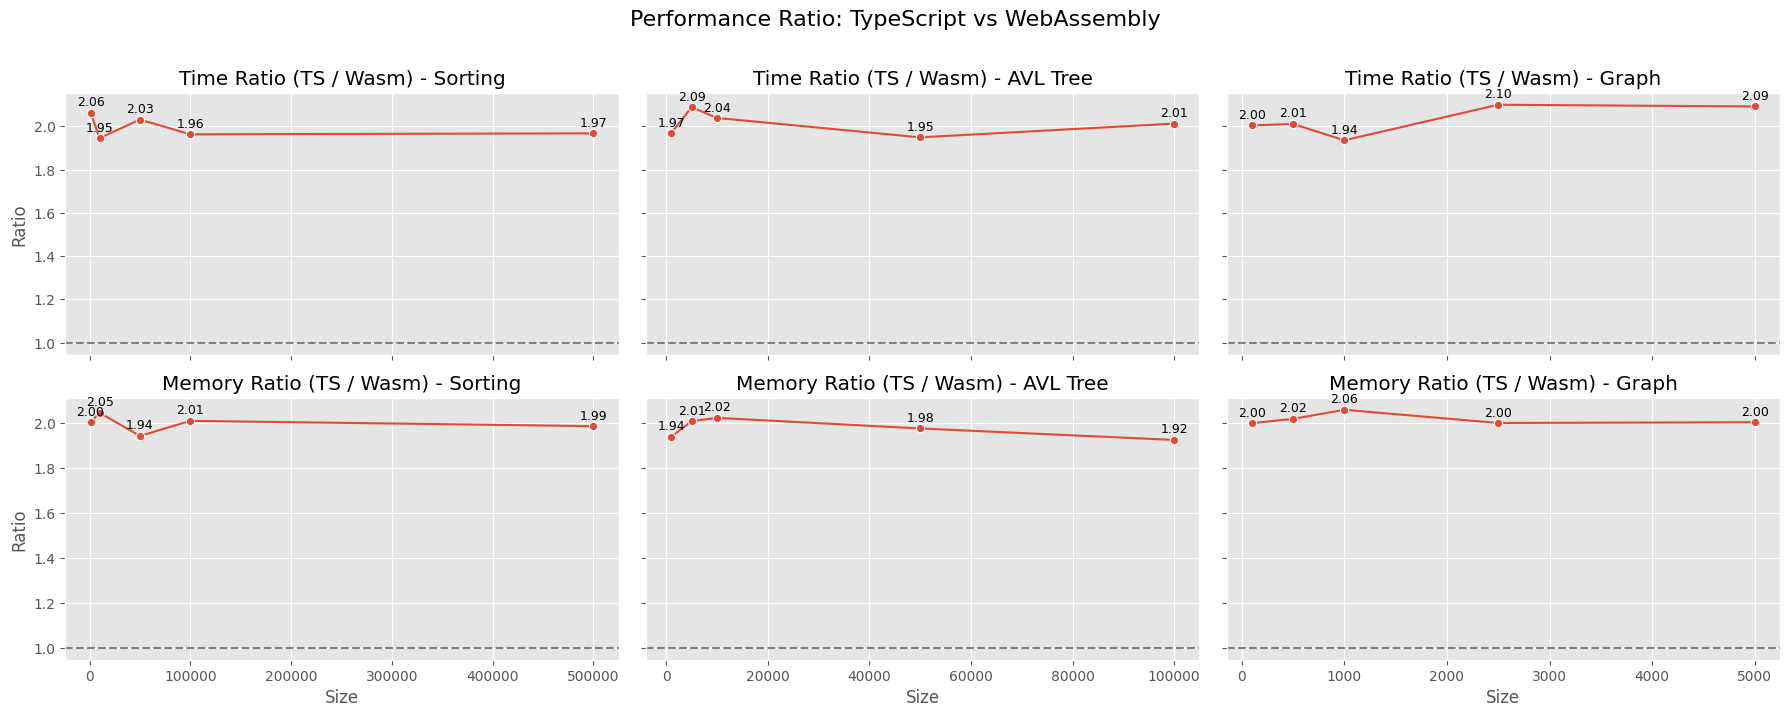

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=num_cols, figsize=(6 * num_cols, 7.5), sharex='col', sharey='row')

for i, test_type in enumerate(test_types):
    df_time = pivot_time[pivot_time["TestType"] == test_type]
    df_mem = pivot_memory[pivot_memory["TestType"] == test_type]

    # Time Ratio
    sns.lineplot(
        data=df_time,
        x="Size", y="TimeRatio",
        marker="o", ax=axes[0, i]
    )
    axes[0, i].axhline(1, color='gray', linestyle='--')
    axes[0, i].set_title(f"Time Ratio (TS / Wasm) - {test_type}")
    axes[0, i].set_xlabel("Size")
    axes[0, i].set_ylabel("Ratio")

    for _, row in df_time.iterrows():
        axes[0, i].annotate(
            f"{row['TimeRatio']:.2f}",
            (row["Size"], row["TimeRatio"]),
            textcoords="offset points",
            xytext=(0, 5),
            ha='center', fontsize=9
        )

    # Memory Ratio
    sns.lineplot(
        data=df_mem,
        x="Size", y="MemoryRatio",
        marker="o", ax=axes[1, i]
    )
    axes[1, i].axhline(1, color='gray', linestyle='--')
    axes[1, i].set_title(f"Memory Ratio (TS / Wasm) - {test_type}")
    axes[1, i].set_xlabel("Size")
    axes[1, i].set_ylabel("Ratio")
    
    for _, row in df_mem.iterrows():
        axes[1, i].annotate(
            f"{row['MemoryRatio']:.2f}",
            (row["Size"], row["MemoryRatio"]),
            textcoords="offset points",
            xytext=(0, 5),
            ha='center', fontsize=9
        )

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
fig.suptitle("Performance Ratio: TypeScript vs WebAssembly", fontsize=16)

output_filepath = output_dir / f"performance_ratio_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
plt.savefig(output_filepath, dpi=300, bbox_inches='tight')
plt.show()


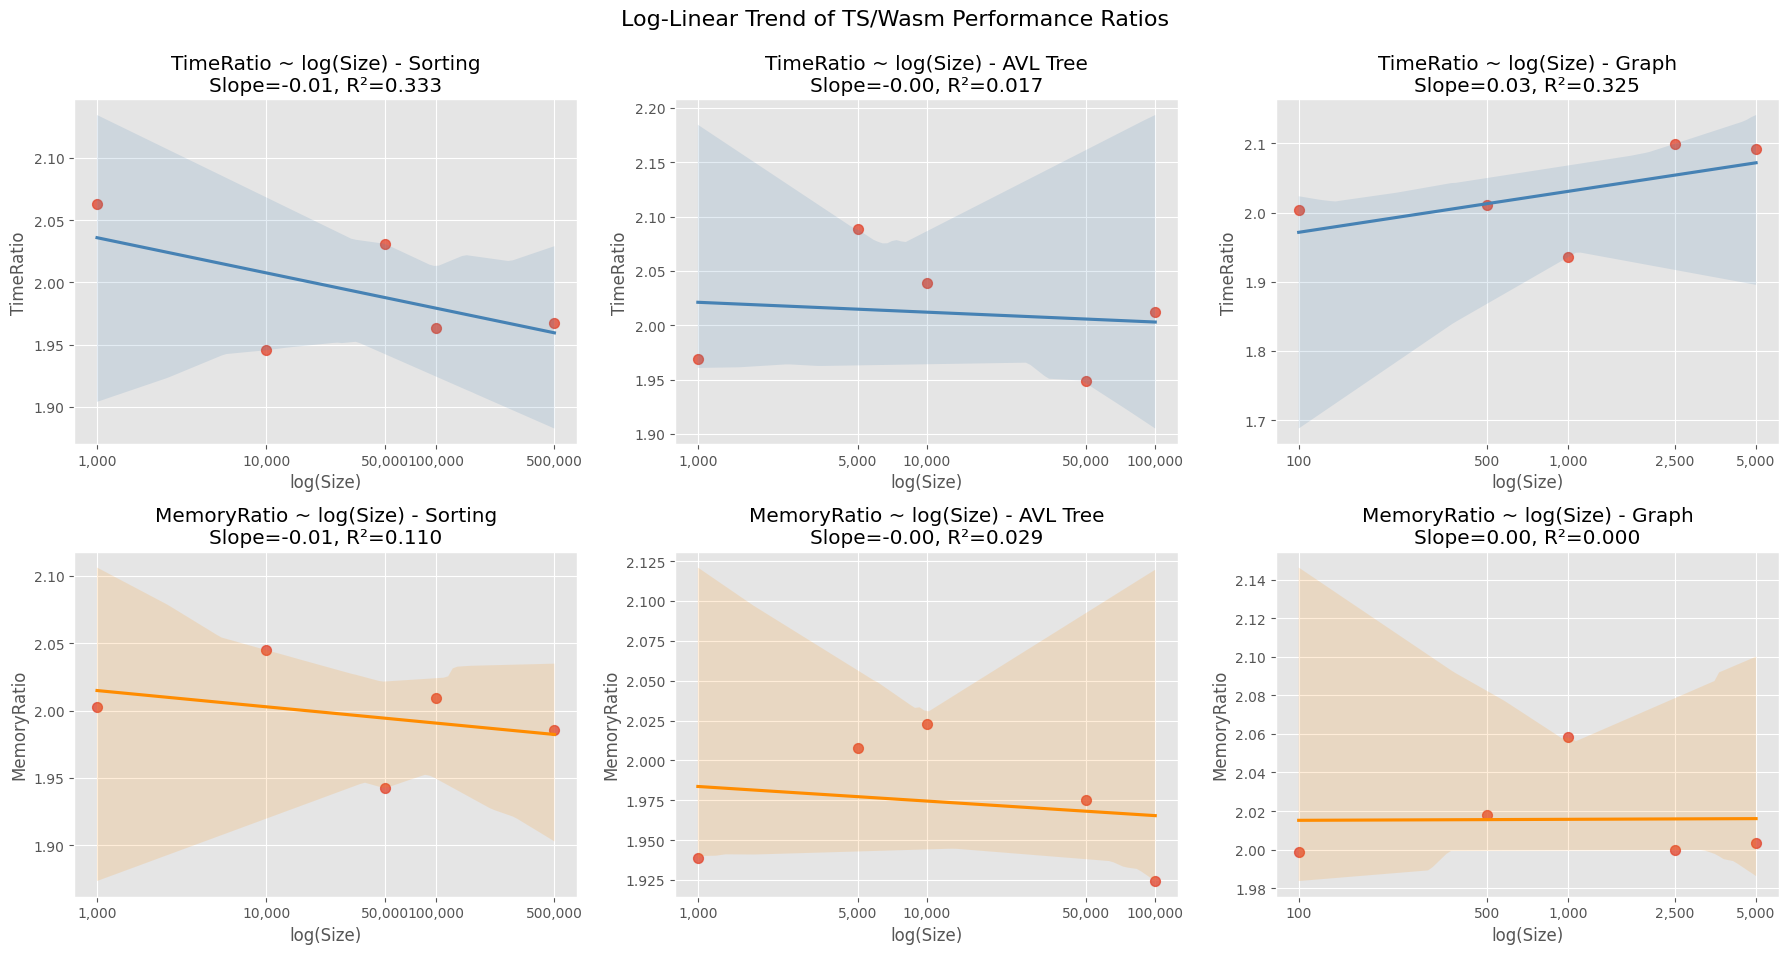

In [11]:
from scipy.stats import linregress

def add_log_size(df):
    df = df.copy()
    df["log_size"] = np.log(df["Size"])
    return df

fig, axes = plt.subplots(nrows=2, ncols=len(test_types), figsize=(6 * len(test_types), 10))

for i, test_type in enumerate(test_types):
    df_time = add_log_size(pivot_time[pivot_time["TestType"] == test_type])
    df_mem = add_log_size(pivot_memory[pivot_memory["TestType"] == test_type])

    # 回帰分析（TimeRatio）
    slope, intercept, r_value, _, _ = linregress(df_time["log_size"], df_time["TimeRatio"])
    sns.regplot(
        data=df_time,
        x="log_size", y="TimeRatio",
        ax=axes[0, i],
        scatter_kws={"s": 50},
        line_kws={"color": "steelblue"}
    )
    axes[0, i].set_title(f"TimeRatio ~ log(Size) - {test_type}\nSlope={slope:.2f}, R²={r_value**2:.3f}")
    axes[0, i].set_xlabel("log(Size)")
    axes[0, i].set_ylabel("TimeRatio")
    axes[0, i].set_xticks(df_time["log_size"])
    axes[0, i].set_xticklabels([f"{int(s):,}" for s in df_time["Size"]])

    # 回帰分析（MemoryRatio）
    slope, intercept, r_value, _, _ = linregress(df_mem["log_size"], df_mem["MemoryRatio"])
    sns.regplot(
        data=df_mem,
        x="log_size", y="MemoryRatio",
        ax=axes[1, i],
        scatter_kws={"s": 50},
        line_kws={"color": "darkorange"}
    )
    axes[1, i].set_title(f"MemoryRatio ~ log(Size) - {test_type}\nSlope={slope:.2f}, R²={r_value**2:.3f}")
    axes[1, i].set_xlabel("log(Size)")
    axes[1, i].set_ylabel("MemoryRatio")
    axes[1, i].set_xticks(df_mem["log_size"])
    axes[1, i].set_xticklabels([f"{int(s):,}" for s in df_mem["Size"]])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Log-Linear Trend of TS/Wasm Performance Ratios", fontsize=16)

output_filepath = output_dir / f"log_linear_trend_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
plt.savefig(output_filepath, dpi=300, bbox_inches='tight')

plt.show()


In [12]:
df["log_size"] = np.log(df["Size"])

metrics = ["Time(ms)", "Memory(MB)"]
implementations = df["Implementation"].unique()
test_types = df["TestType"].unique()

results = []

for metric in metrics:
    for test_type in test_types:
        for impl in implementations:
            subset = df[(df["TestType"] == test_type) & (df["Implementation"] == impl)]
            if len(subset) >= 2:
                slope, intercept, r_value, _, _ = linregress(subset["log_size"], subset[metric])
                results.append({
                    "Metric": metric,
                    "TestType": test_type,
                    "Implementation": impl,
                    "Slope": round(slope, 4),
                    "R²": round(r_value ** 2, 4)
                })

df_results = pd.DataFrame(results)

In [13]:
df_results.style.background_gradient(cmap='viridis').set_table_attributes('style="width: 100%;"')

,Metric,TestType,Implementation,Slope,R²
0,Time(ms),Sorting,TypeScript,-0.506000,0.001400
1,Time(ms),Sorting,WebAssembly,-0.099700,0.000200
2,Time(ms),AVL Tree,TypeScript,0.058600,0.000000
3,Time(ms),AVL Tree,WebAssembly,0.075500,0.000100
4,Time(ms),Graph,TypeScript,0.392600,0.000300
5,Time(ms),Graph,WebAssembly,-0.112100,0.000100
6,Memory(MB),Sorting,TypeScript,0.006900,0.000000
7,Memory(MB),Sorting,WebAssembly,0.010100,0.000200
8,Memory(MB),AVL Tree,TypeScript,-0.011000,0.000000
9,Memory(MB),AVL Tree,WebAssembly,-0.000700,0.000000


In [14]:
with open("../data/slope_results.md", mode="w") as f:
    f.write(df_results.to_markdown(index=False))
    f.write("\n\n")
    f.write(df_results.to_latex(index=False, escape=False))

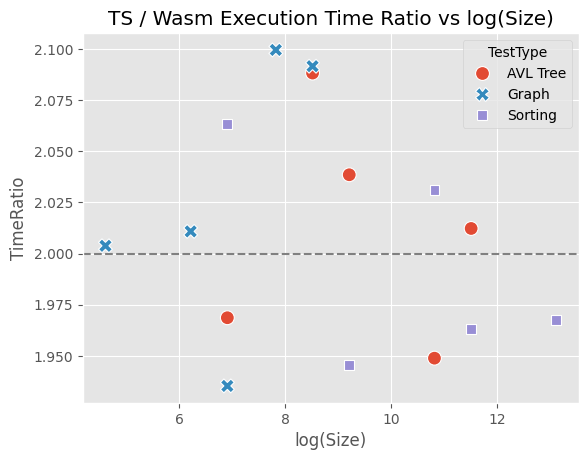

In [15]:
df_ratio = pivot_time.copy()
df_ratio["log_size"] = np.log(df_ratio["Size"])

sns.scatterplot(
    data=df_ratio,
    x="log_size", y="TimeRatio",
    hue="TestType",
    style="TestType",
    s=100
)
plt.axhline(2, linestyle='--', color='gray')
plt.title("TS / Wasm Execution Time Ratio vs log(Size)")
plt.xlabel("log(Size)")
plt.ylabel("TimeRatio")
plt.show()
